In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

# Perform comprehensive skill analysis including association rules mining and company clustering
def analyze_skills_data(
    file_path,
    min_support=0.015, # Minimum support for association rules
    min_confidence=0.8, # Minimum confidence for association rules
    num_clusters=5, # Number of company clusters
    top_n_rules=10, # Number of top association rules to visualize
    top_n_itemsets=10, # Number of top itemsets to visualize
    top_n_skills=10, # Number of top skills per cluster to show
    show_plots=True # Whether to display visualization plots
):

    # Load and preprocess data
    df = pd.read_csv(file_path)
    df['skills_list'] = df['skill'].apply(
        lambda x: [skill.strip() for skill in str(x).split('、') if skill.strip()]
    )
    df = df[df['skills_list'].apply(len) > 0]

    # Association rule mining
    te = TransactionEncoder()
    te_ary = te.fit(df['skills_list']).transform(df['skills_list'])
    df_skills = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(df_skills, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    print("Top Association Rules by Confidence:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence']]
          .sort_values('confidence', ascending=False)
          .head(top_n_rules))

    # Company clustering
    company_skills = df.groupby('company')['skills_list'].sum()
    company_skill_counts = company_skills.apply(Counter)

    all_skills = sorted({skill for skills in company_skills for skill in skills if skill})
    company_skill_df = pd.DataFrame(0, index=company_skills.index, columns=all_skills)

    for company, skill_count in company_skill_counts.items():
        for skill, count in skill_count.items():
            if skill:
                company_skill_df.loc[company, skill] = count

    tfidf = TfidfTransformer()
    company_skill_tfidf = tfidf.fit_transform(company_skill_df)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(company_skill_tfidf)
    company_skill_df['cluster'] = clusters

    print("\nTarget Company Skill Checklist:")
    for cluster in range(num_clusters):
        cluster_df = company_skill_df[company_skill_df['cluster'] == cluster]
        skill_sums = cluster_df.drop('cluster', axis=1).sum().sort_values(ascending=False)
        top_skills = skill_sums.head(top_n_skills).index.tolist()
        print(f"Cluster {cluster} (Size: {len(cluster_df)}): {top_skills}")

    # Visualization
    if show_plots:
        # Association Rules Network
        plt.figure(figsize=(12, 8))
        G = nx.DiGraph()
        top_rules = rules.sort_values('confidence', ascending=False).head(top_n_rules)

        for _, row in top_rules.iterrows():
            for ant in row['antecedents']:
                for con in row['consequents']:
                    G.add_edge(ant, con, weight=row['confidence'])

        pos = nx.spring_layout(G, seed=42)
        nx.draw(G, pos, with_labels=True, node_size=2000,
                node_color='lightblue', font_size=10, arrowsize=20)
        edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
        plt.title(f"Top {top_n_rules} Skill Association Rules")
        plt.show()

        # Frequent Itemsets
        plt.figure(figsize=(12, 6))
        top_itemsets = frequent_itemsets.sort_values('support', ascending=False).head(top_n_itemsets)
        plt.barh([', '.join(item) for item in top_itemsets['itemsets']],
                 top_itemsets['support'], color='skyblue')
        plt.xlabel('Support')
        plt.title(f'Top {top_n_itemsets} Frequent Skill Combinations')
        plt.gca().invert_yaxis()
        plt.show()

        # Company Clusters (PCA)
        pca = PCA(n_components=2)
        company_skill_pca = pca.fit_transform(company_skill_tfidf.toarray())
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(company_skill_pca[:, 0], company_skill_pca[:, 1],
                             c=clusters, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.title('Company Clusters by Skill Preferences')
        plt.show()

        # Skills per Cluster
        for cluster in range(num_clusters):
            plt.figure(figsize=(12, 6))
            cluster_df = company_skill_df[company_skill_df['cluster'] == cluster]
            skill_sums = cluster_df.drop('cluster', axis=1).sum().sort_values(ascending=False).head(top_n_skills)
            plt.barh(skill_sums.index, skill_sums.values, color='salmon')
            plt.xlabel('Frequency')
            plt.title(f'Top {top_n_skills} Skills in Cluster {cluster}')
            plt.gca().invert_yaxis()
            plt.show()

    return {
        'frequent_itemsets': frequent_itemsets,
        'association_rules': rules,
        'company_skill_matrix': company_skill_df,
        'cluster_model': kmeans
    }


Top Association Rules by Confidence:
                             antecedents          consequents   support  \
7        (Virtual Private Network (VPN))    (Troubleshooting)  0.015320   
9            (Statistics, Communication)  (Analytical Skills)  0.026462   
18         (Problem Solving, Networking)    (Troubleshooting)  0.015320   
19       (Networking, Technical Support)    (Troubleshooting)  0.023677   
14           (Communication, Networking)    (Troubleshooting)  0.015320   
2                   (Oral Communication)      (Communication)  0.018106   
12         (Research Skills, Statistics)  (Analytical Skills)  0.018106   
16  (Information Technology, Networking)    (Troubleshooting)  0.018106   
5                           (Google Ads)   (Google Analytics)  0.015320   
4                           (Google Ads)  (Digital Marketing)  0.015320   

    confidence  
7     1.000000  
9     1.000000  
18    1.000000  
19    1.000000  
14    1.000000  
2     0.928571  
12    0.928571  
1

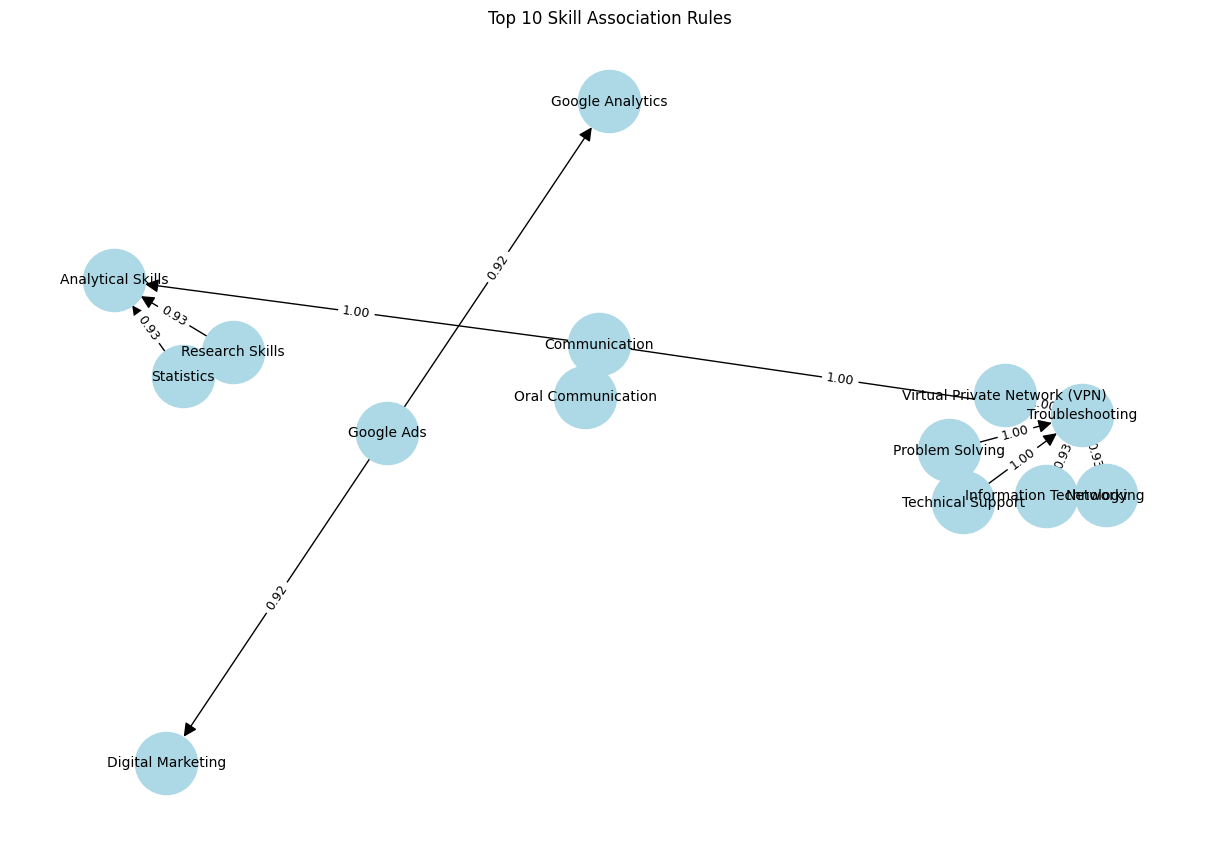

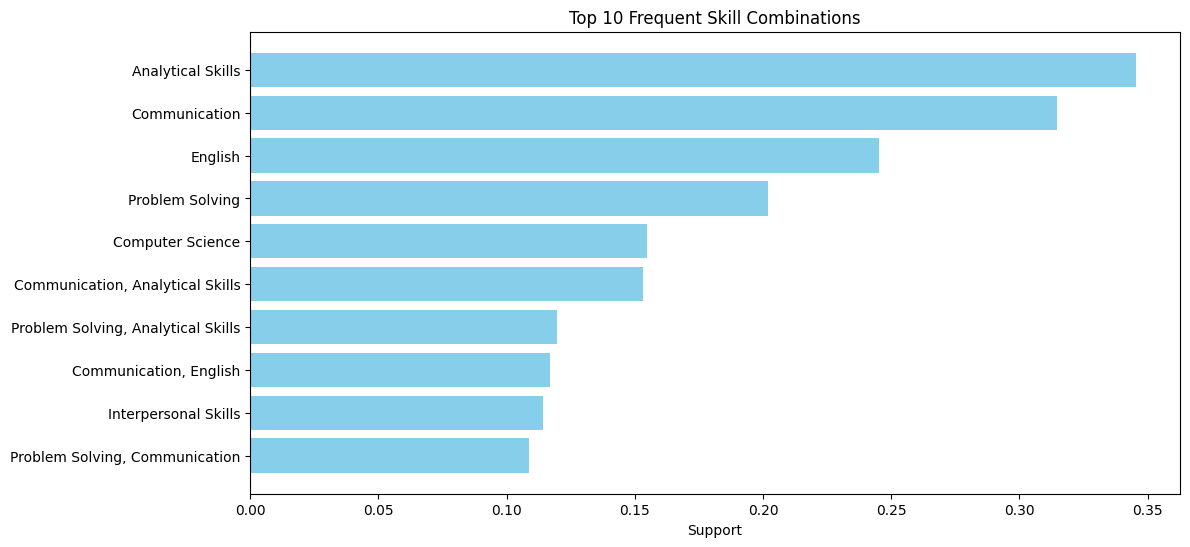

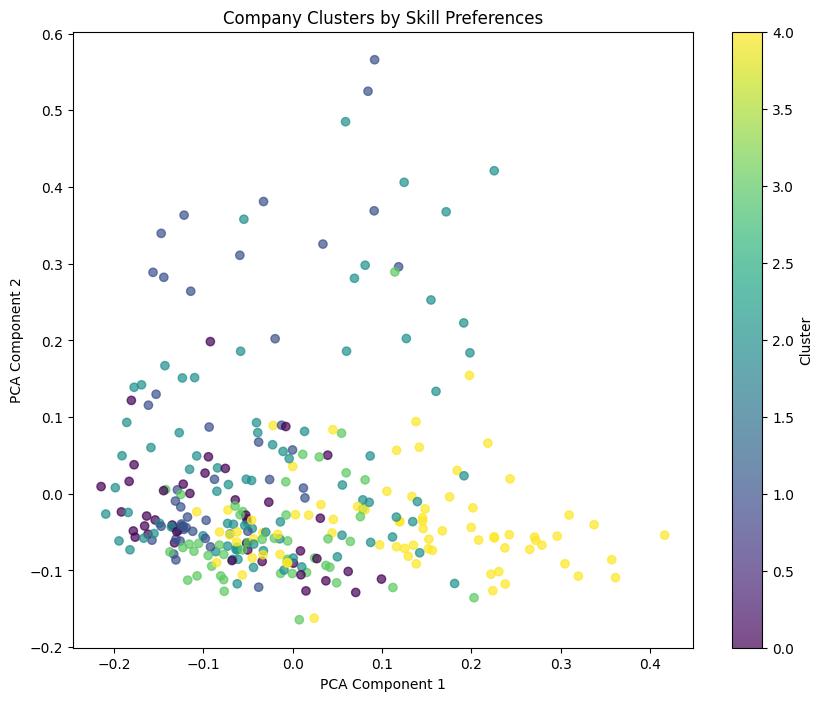

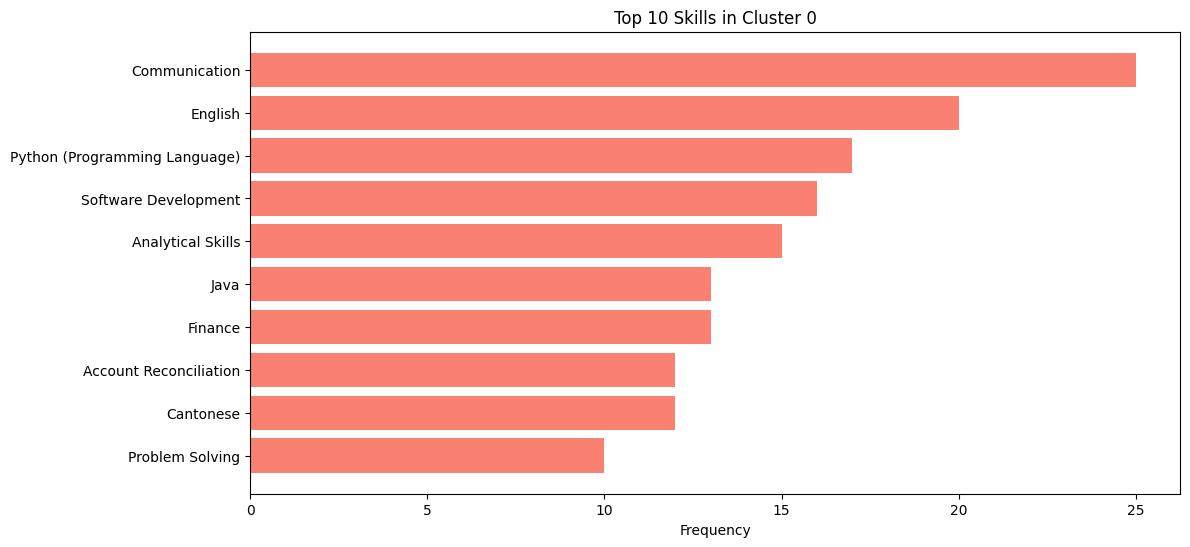

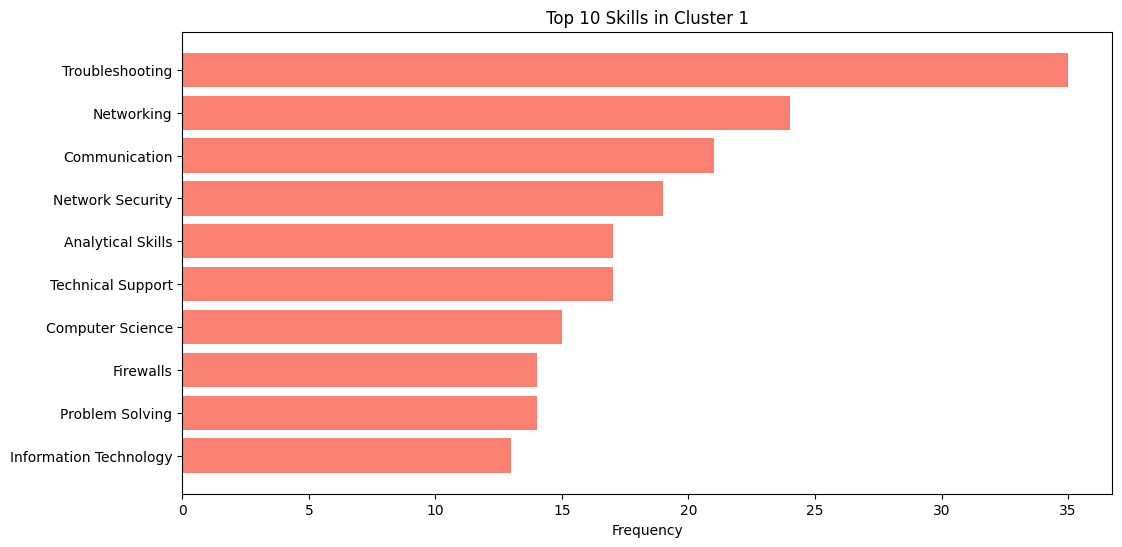

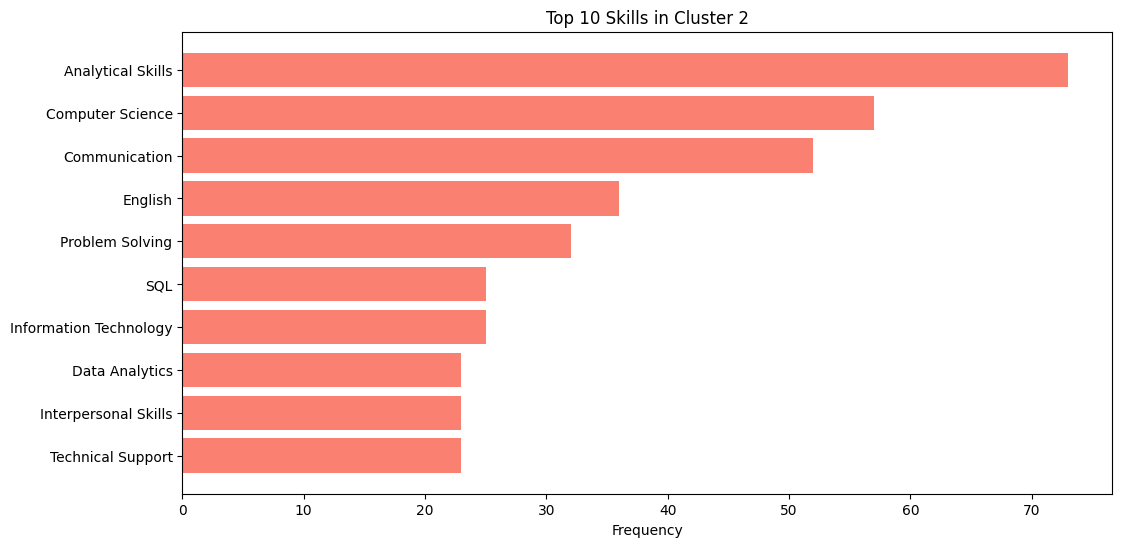

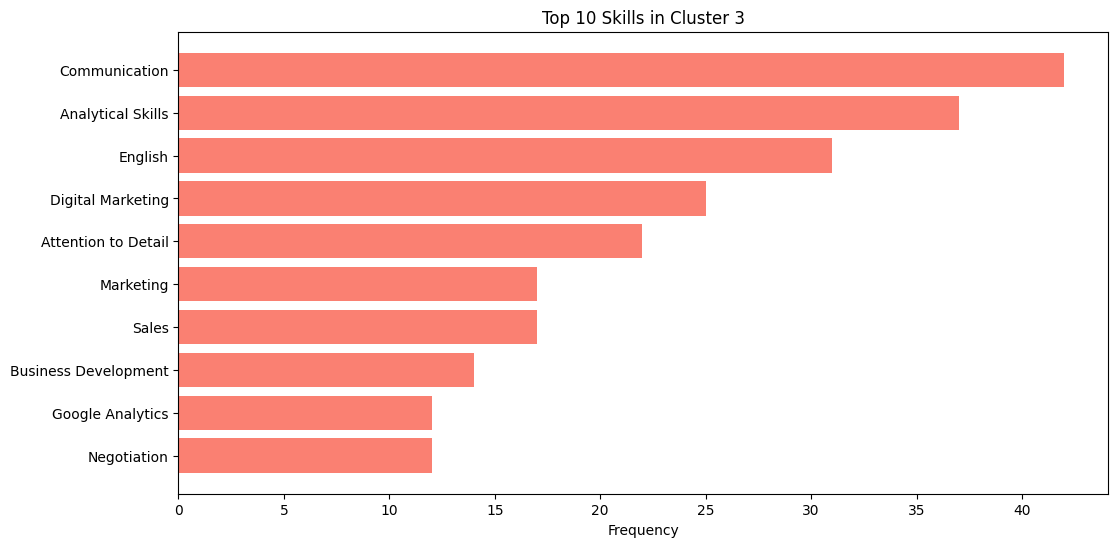

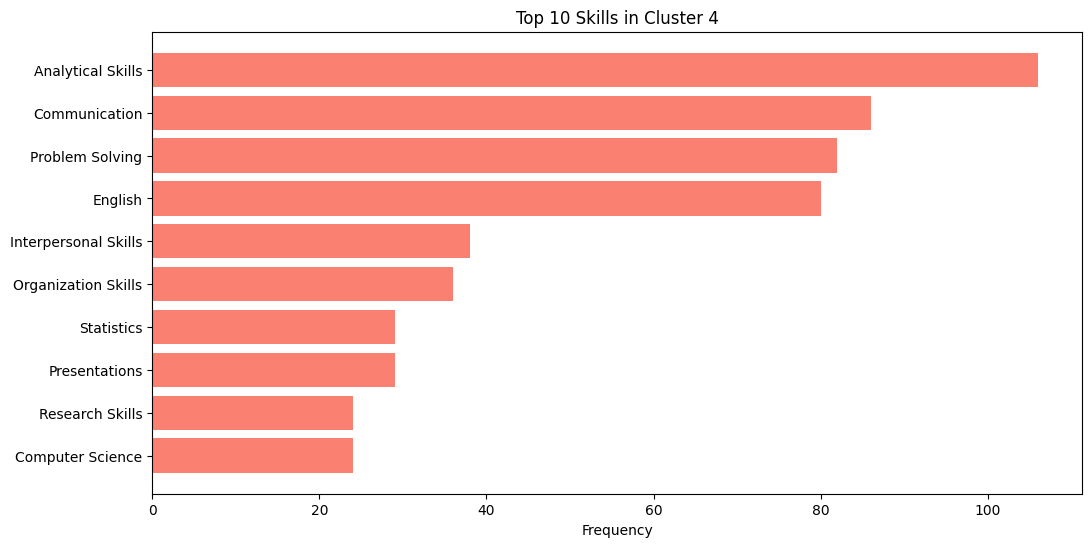

In [ ]:
if __name__ == "__main__":
    results = analyze_skills_data(
        file_path='preprocessed_linkedin_data.csv',
        min_support=0.015,
        min_confidence=0.8,
        num_clusters=5,
        top_n_rules=10,
        top_n_itemsets=10,
        top_n_skills=10,
        show_plots=True
    )